# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [6]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
def pretty_print(df):
    return display(HTML(df.to_html().replace("\n","")))

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download the Surveillance Videos

In this tutorial, we focus on the UA-DETRAC benchmark. UA-DETRAC is a challenging real-world multi-object detection and multi-object tracking benchmark. The dataset consists of 10 hours of videos captured with a Cannon EOS 550D camera at 24 different locations at Beijing and Tianjin in China.

In [2]:
# Getting the video files
!wget -nc "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" -O ua_detrac.mp4

--2023-10-11 05:18:21--  https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k00wge9exwkfxz6/ua_detrac.mp4 [following]
--2023-10-11 05:18:21--  https://www.dropbox.com/s/raw/k00wge9exwkfxz6/ua_detrac.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2d84f32945e1d5759f40956a5.dl.dropboxusercontent.com/cd/0/inline/CFZ0SxKEZ8AMDL_yGGZUbGKx5aXsnDaLia0Hk1NAcysBB8jOSBd3mtWBTcB2TYxTlJ2Xs91h6oKBjucUHWlq0Q2FlBVIVxEjfZlAXCR3kLsVFmEAS6pfBR1vLL8xUnije0mcsj1BmBIY1hTpTyCf31-K/file# [following]
--2023-10-11 05:18:21--  https://ucf2d84f32945e1d5759f40956a5.dl.dropboxusercontent.com/cd/0/inline/CFZ0SxKEZ8AMDL_yGGZUbGKx5aXsnDaLia0Hk1NAcysBB8jOSBd3mtWBTcB2TYxTlJ2Xs91h6oKBjucUHWlq0Q2FlBVIV

### Load the videos for analysis

We use a regular expression to load all the videos into the table in a single command

In [3]:
cursor.query("DROP TABLE IF EXISTS ObjectDetectionVideos;").df()
cursor.query("LOAD VIDEO 'ua_detrac.mp4' INTO ObjectDetectionVideos").df()

,0
0,Number of loaded VIDEO: 1


### Register YOLO Object Detector as an User-Defined Function (UDF) in EvaDB

In [4]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS Yolo
    TYPE ultralytics
    MODEL 'yolov8m.pt';
""").df()

,0
0,"Function Yolo already exists, nothing added."


### Run the YOLO Object Detector on the video

In [7]:
yolo_query = cursor.query("""
    SELECT id, Yolo(data)
    FROM ObjectDetectionVideos
    WHERE id < 20
""")
response = yolo_query.df()
response

,id,labels,bboxes,scores
0,0,"[car, car, car, car, car, car, person, car, ca...","[[828.603515625, 277.0185546875, 959.627929687...","[0.91, 0.86, 0.85, 0.83, 0.76, 0.73, 0.72, 0.7..."
1,1,"[car, car, car, car, car, car, car, car, car, ...","[[832.1552734375, 278.1465759277344, 959.63824...","[0.92, 0.85, 0.84, 0.83, 0.78, 0.76, 0.76, 0.7..."
2,2,"[car, car, car, car, car, car, car, person, ca...","[[835.5642700195312, 279.1688537597656, 959.64...","[0.92, 0.84, 0.84, 0.82, 0.81, 0.75, 0.73, 0.7..."
3,3,"[car, car, car, car, car, car, car, car, car, ...","[[839.2291259765625, 279.8769836425781, 959.63...","[0.91, 0.84, 0.82, 0.8, 0.8, 0.75, 0.74, 0.72,..."
4,4,"[car, car, car, car, car, car, car, car, car, ...","[[843.063232421875, 280.8487548828125, 959.625...","[0.9, 0.85, 0.83, 0.8, 0.76, 0.73, 0.72, 0.72,..."
5,5,"[car, car, car, car, car, car, person, car, ca...","[[847.2269897460938, 282.40478515625, 959.6654...","[0.89, 0.86, 0.84, 0.8, 0.78, 0.74, 0.72, 0.72..."
6,6,"[car, car, car, car, car, car, car, person, ca...","[[850.6966552734375, 283.1654052734375, 959.43...","[0.89, 0.87, 0.85, 0.81, 0.79, 0.73, 0.72, 0.7..."
7,7,"[car, car, car, car, car, car, car, car, car, ...","[[854.817626953125, 283.7934265136719, 959.555...","[0.9, 0.87, 0.84, 0.83, 0.83, 0.79, 0.73, 0.67..."
8,8,"[car, car, car, car, car, car, person, car, ca...","[[859.0677490234375, 285.2332458496094, 959.82...","[0.89, 0.88, 0.83, 0.82, 0.79, 0.71, 0.68, 0.6..."
9,9,"[car, car, car, car, car, car, car, person, ca...","[[862.5375366210938, 286.3861083984375, 959.53...","[0.88, 0.87, 0.84, 0.82, 0.8, 0.75, 0.74, 0.74..."


### Visualizing output of the Object Detector on the video

In [8]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()

    while ret:
        df = detections
        df = df[['bboxes', 'labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness)
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()


        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

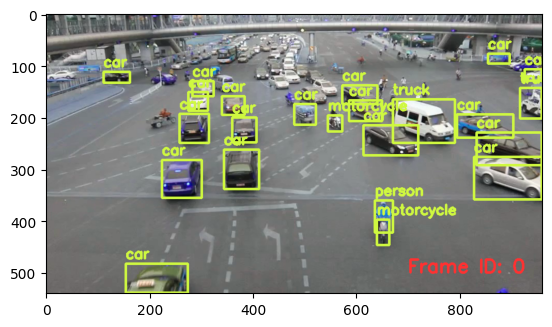

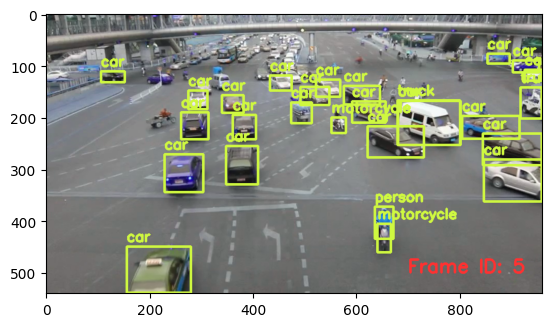

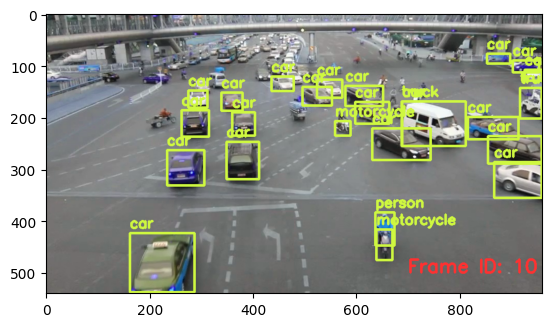

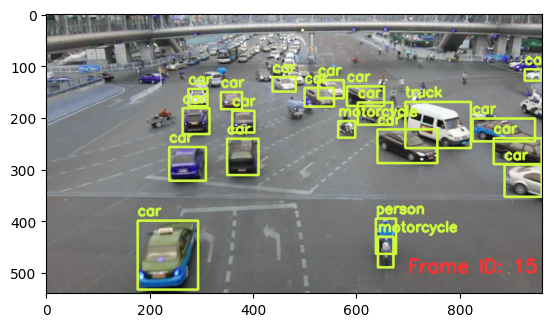

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\t5X...')

In [9]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)
Video.from_file(output_path)

### Drop the function if needed

In [10]:
cursor.query("DROP FUNCTION IF EXISTS Yolo").df()

,0
0,Function Yolo successfully dropped
